# Case 21.2 German Credit

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
%matplotlib inline
import warnings
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from dmba import classificationSummary, gainsChart, liftChart


DATA = Path('.').resolve().parent / 'data'

# Load the data

In [2]:
data = pd.read_csv(DATA / 'GermanCredit.csv', index_col='OBS#')
print(data.shape)
data.head()

(1000, 31)


,CHK_ACCT,DURATION,HISTORY,NEW_CAR,USED_CAR,FURNITURE,RADIO/TV,EDUCATION,RETRAINING,AMOUNT,...,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,RESPONSE
OBS#,,,,,,,,,,,,,,,,,,,,,
1,0,6,4,0,0,0,1,0,0,1169,...,67,0,0,1,2,2,1,1,0,1
2,1,48,2,0,0,0,1,0,0,5951,...,22,0,0,1,1,2,1,0,0,0
3,3,12,4,0,0,0,0,1,0,2096,...,49,0,0,1,1,1,2,0,0,1
4,0,42,2,0,0,1,0,0,0,7882,...,45,0,0,0,1,2,2,0,0,1
5,0,24,3,1,0,0,0,0,0,4870,...,53,0,0,0,2,2,2,0,0,0


In [3]:
data.RESPONSE.value_counts()

1    700
0    300
Name: RESPONSE, dtype: int64

In [4]:
data.columns

Index(['CHK_ACCT', 'DURATION', 'HISTORY', 'NEW_CAR', 'USED_CAR', 'FURNITURE',
       'RADIO/TV', 'EDUCATION', 'RETRAINING', 'AMOUNT', 'SAV_ACCT',
       'EMPLOYMENT', 'INSTALL_RATE', 'MALE_DIV', 'MALE_SINGLE',
       'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT',
       'REAL_ESTATE', 'PROP_UNKN_NONE', 'AGE', 'OTHER_INSTALL', 'RENT',
       'OWN_RES', 'NUM_CREDITS', 'JOB', 'NUM_DEPENDENTS', 'TELEPHONE',
       'FOREIGN', 'RESPONSE'],
      dtype='object')

Note: The opportunity cost table and the average net profit table are represented in a way that is different to the way we define the confusion matrix in the book. We therefore define the two matrices here transposed. (the tables in the book will be revised, so it may already happened for you).

In [5]:
cost = pd.DataFrame([{'accept': 0, 'reject': 100}, {'accept': 500, 'reject': 0}], index=['good', 'bad'])
print('Opportunity cost table:\n', cost)
print()
gain = pd.DataFrame([{'accept': 100, 'reject': 0}, {'accept': -500, 'reject': 0}], index=['good', 'bad'])
print('Average net profit:\n', gain)

Opportunity cost table:
       accept  reject
good       0     100
bad      500       0

Average net profit:
       accept  reject
good     100       0
bad     -500       0


# Assignment

## Step 1. Analyze your data
Review the predictor variables and guess what their role in a credit decision might be.  Are there any surprises in the data?

In [6]:
# Group categorical columns based on information
categorical_columns = [column for column in data.columns if len(data[column].unique()) <= 5]
# print(categorical_columns)

financial_history = ['CHK_ACCT', 'HISTORY', 'SAV_ACCT', 'OTHER_INSTALL', 'NUM_CREDITS']
credit_information = ['INSTALL_RATE', ]
customer_information = ['EMPLOYMENT', 'MALE_DIV', 'MALE_SINGLE', 'MALE_MAR_or_WID', 'CO-APPLICANT', 'GUARANTOR', 
                      'PRESENT_RESIDENT', 'REAL_ESTATE', 'PROP_UNKN_NONE', 'RENT', 'OWN_RES', 'JOB',
                      'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN']
purpose = ['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO/TV', 'EDUCATION', 'RETRAINING']

### Financial history
We can see that information about the financial situation has a strong impact on wether the bank assesses a customer as having good or bad credit. 

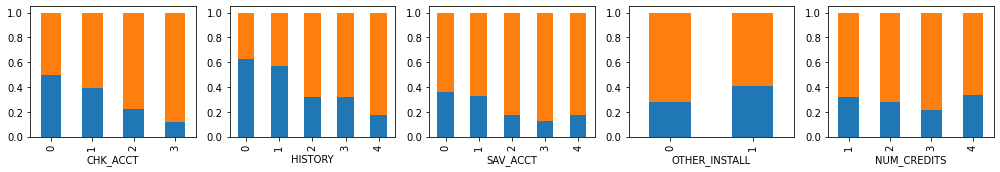

In [7]:
def stacked_barcharts(columns, ncols=5):
    nrows = 1 + (len(columns) - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 2.5))
    for i, column in enumerate(columns):
        # calculate pivot table
        pivot = pd.crosstab(data['RESPONSE'], data[column])
        # divide by column sums to get frequency per column
        freq = pivot.div(pivot.sum())
        # display as stacked bar chart with 100%
        ax = axes[i // 5, i % 5] if nrows > 1 else axes[i]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            freq.transpose().plot(kind='bar', ax=ax, stacked=True, legend=False)
    for i in range(len(columns), nrows * 5):
        ax = axes[i // 5, i % 5] if nrows > 1 else axes[i]
        fig.delaxes(ax)
    plt.tight_layout()

# good credit is shown in orange (700 cases), bad credit in blue (300 cases)
stacked_barcharts(financial_history)

### Credit information
- Increasing `INSTALL_RATE` (higher percentage of disposable income) leads to a slight reduction 
- Credits with longer duration have a higher ratio of 'bad' customers
- Credits with a larger amount tend to have a higher ratio of 'bad' customers

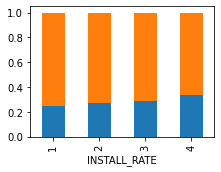

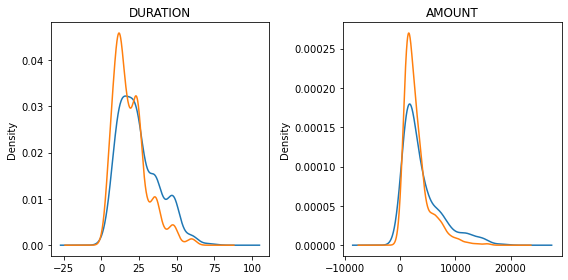

In [8]:
stacked_barcharts(credit_information)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
for i, column in enumerate(['DURATION', 'AMOUNT']):
    for response, group in data[['RESPONSE', column]].groupby('RESPONSE'):
        group[column].plot.density(ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()

### Customer information
Some of the customer related columns show an effect on the credit assessment. In particular, home ownership shows an effect. Older customers are more likely to be good customers. 

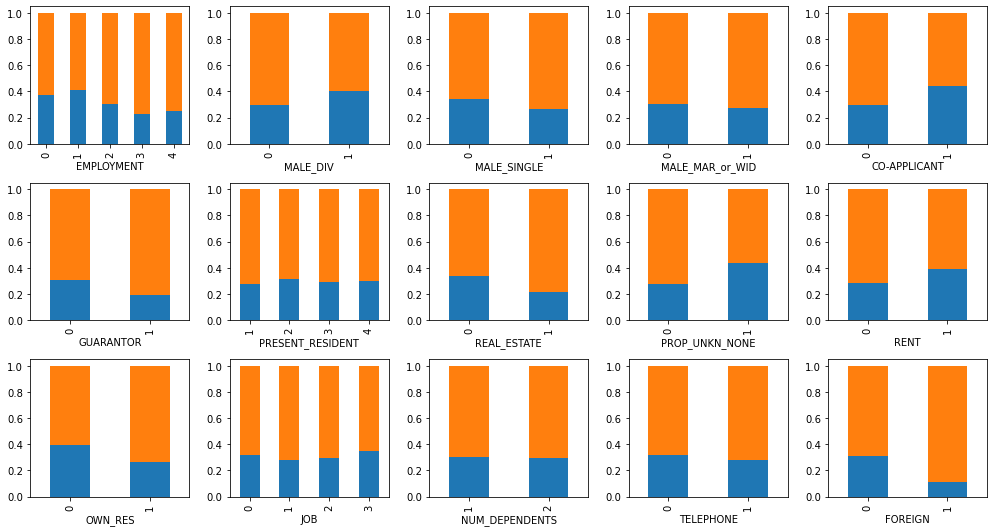

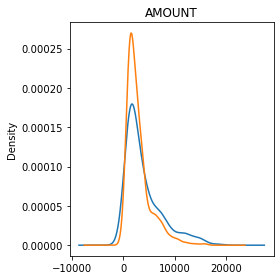

In [9]:
stacked_barcharts(customer_information)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
for response, group in data[['RESPONSE', column]].groupby('RESPONSE'):
    group[column].plot.density(ax=ax)
ax.set_title(column)
plt.tight_layout()

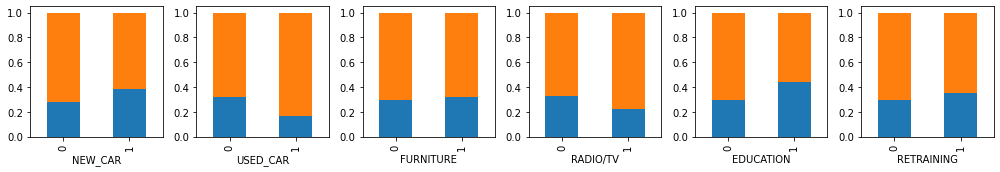

In [10]:
stacked_barcharts(purpose, ncols=6)

## Step 2 Classification models
Divide the data into training and validation partitions, and develop classification models using the following data mining techniques: 


- logistic regression
- classification trees, and
- neural networks

In [11]:
X = data.drop(columns=['RESPONSE'])
y = data['RESPONSE']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)#### Define helper functions

#### Define helper functions

In [12]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y, model.predict(train_X))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)
    return confusion_matrix(valid_y, valid_pred)

### Step 2.1 Logistic regression model

In [13]:
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)
logit_reg_confusion = confusionMatrices(logit_reg, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.7967)

       Prediction
Actual   0   1
     0 106  79
     1  43 372
Logistic regression - validation results
Confusion Matrix (Accuracy 0.7550)

       Prediction
Actual   0   1
     0  53  62
     1  36 249


### Step 2.2 Decision tree classifier

In [14]:
classTree = DecisionTreeClassifier()
classTree.fit(train_X, train_y)

# Start with an initial guess for parameters
param_grid = {
    'max_depth': [5, 10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 90, 100, 110], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 10)), 
    'min_samples_split': list(range(75, 85)), 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

classTree = gridSearch.best_estimator_
classTree_confusion = confusionMatrices(classTree, 'Decision tree')

Initial score:  0.7233333333333334
Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.005, 'min_samples_split': 80}
Improved score:  0.725
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.005, 'min_samples_split': 75}
Decision tree - training results
Confusion Matrix (Accuracy 0.7733)

       Prediction
Actual   0   1
     0  93  92
     1  44 371
Decision tree - validation results
Confusion Matrix (Accuracy 0.7275)

       Prediction
Actual   0   1
     0  43  72
     1  37 248


### Step 2.3 Neural network

In [15]:
param_grid = {
    'hidden_layer_sizes': list(range(2, 30)),
}
neuralNet = MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=5000)

gridSearch = GridSearchCV(neuralNet, param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

neuralNet = gridSearch.best_estimator_
neuralNet_confusion = confusionMatrices(neuralNet, 'Neural network')

Improved score:  0.7516666666666666
Improved parameters:  {'hidden_layer_sizes': 17}
Neural network - training results
Confusion Matrix (Accuracy 0.7617)

       Prediction
Actual   0   1
     0 102  83
     1  60 355
Neural network - validation results
Confusion Matrix (Accuracy 0.7375)

       Prediction
Actual   0   1
     0  56  59
     1  46 239


## Step 3. Analyze the models
Choose one model from each technique and report the confusion matrix and the cost/gain matrix for the validation data.  Which technique has the highest net profit?

Multiply the confusion matrix with the `cost` and `gain` matrices element wise and sum the products.

In [16]:
# Logistic regression
print('cost: ', (logit_reg_confusion * cost).to_numpy().sum())
print('gain: ', (logit_reg_confusion * gain).to_numpy().sum())

cost:  24200
gain:  -12700


In [17]:
# Decision tree classifier
print('cost: ', (classTree_confusion * cost).to_numpy().sum())
print('gain: ', (classTree_confusion * gain).to_numpy().sum())


cost:  25700
gain:  -14200


In [18]:
# Neural network classifier
print('cost: ', (neuralNet_confusion * cost).to_numpy().sum())
print('gain: ', (neuralNet_confusion * gain).to_numpy().sum())

cost:  28900
gain:  -17400


## Step 4. Improve the model
Let us try and improve our performance.  Rather than accept the default classification of all applicants' credit status, use the estimated probabilities (propensities) from the logistic regression (where _success_ means 1) as a basis for selecting the best credit risks first, followed by poorer-risk applicants. Create a vector containing the net profit for each record in the validation set. Use this vector to create a decile-wise lift chart for the validation set that incorporates the net profit. 

a. How far into the validation data should you go to get maximum net profit?  (Often, this is specified as a percentile or rounded to deciles.)

b. If this logistic regression model is used to score to future applicants, what "probability of success" cutoff should be used in extending credit?

In [19]:
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'profit': [100 if v == 1 else -500 for v in valid_y]
                            })

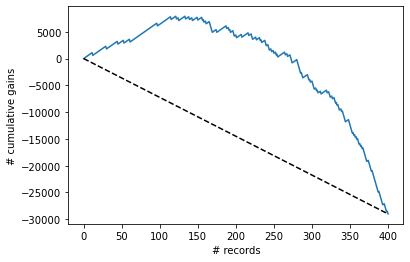

In [20]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
gainsChart(df.profit)
plt.show()

a.) The cumulative gain grows until record 150. This corresponds to 150 / 400 = 37.5% of the validation set.

b.) If we plot the ordered probability `p(1)` we can determine the cutoff value visually. 

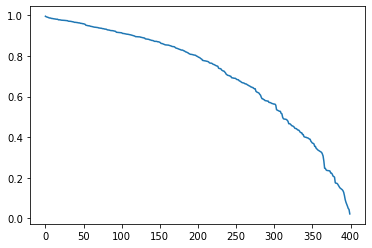

In [21]:
df['p(1)'].reset_index(drop=True).plot()
plt.show()

Alternatively, we can look at the 150-th row of the sorted data frame `df`. 

In [22]:
df.iloc[150:151, :]

,actual,p(0),p(1),profit
OBS#,,,,
633,1,0.132674,0.867326,100


Based on this analysis, we would choose a cut-off of 0.87. 